In [56]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Preliminary Data Cleaning

In [57]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
# Set seeds for reproducibility for whole kernel
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

df = pd.read_csv('lung cancer survey.csv')
df_no_na = df.dropna()

df_age = df_no_na[df_no_na["AGE"] > 21]

# Assuming 'age' is in the second column (index 0) of X
age_index = 1

X = df_age.drop('LUNG_CANCER', axis=1).values
y = df_age['LUNG_CANCER'].values
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=888)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler only on the age column in X_train
X_train_age = X_train[:, age_index].reshape(-1, 1)
scaler.fit(X_train_age)

# Transform the age column in X_train and X_val
X_train[:, age_index] = scaler.transform(X_train_age).flatten()
X_val[:, age_index] = scaler.transform(X_val[:, age_index].reshape(-1, 1)).flatten()

X_train

StandardScaler()

array([[ 1.        ,  1.16977204,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 1.        , -1.2946817 ,  1.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.        ,  0.64167481,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  1.25778824,  0.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        , -0.32650345,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 1.        , -1.11864929,  1.        , ...,  1.        ,
         0.        ,  1.        ]])

# Base Neural Network Model

The model below considers 3 hidden layers, each holding 10 nodes.

This is just a baseline model to understand the model parameters better

In [3]:
# Set seeds for reproducibility
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

# Creating the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(15,)),  # Adjust input shape based on feature count
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Train the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=len(X_train), validation_data=(X_val, y_val), verbose=0)


In [4]:
# Get model predictions for validation set
y_val_pred = model.predict(X_val)
y_val_pred = (y_val_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate Precision, Recall, and F1-score
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
Precision: 0.8863
Recall: 0.9853
F1-score: 0.9332


# Hyperparameter tuning (Random Search) 

In [4]:
# Simplify parameters with 6 layers
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense
from keras_tuner import HyperModel, RandomSearch, BayesianOptimization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad

class MyHyperModel(HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build(self, hp):
        model = Sequential()
        model.add(layers.Input(shape=(self.input_dim,)))

        # First hidden layer with tunable units and activation
        model.add(Dense(
            units=hp.Int('units_1', min_value=8, max_value=45), # Tune units from a selection from 8 to 45
            activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid', 'linear']) # Tune activation from a selection
        ))

        # Adding up to 5 more hidden layers based on the hp.Int range from 1 to 5 additional layers
        for i in range(hp.Int('num_layers', 1, 5)):  # This creates 2 to 6 total hidden layers
            model.add(Dense(
                units=hp.Int(f'units_{i+2}', min_value=8, max_value=45), # Tune units from a selection from 8 to 45
                activation=hp.Choice(f'activation_{i+2}', values=['relu', 'tanh', 'sigmoid', 'linear']) # Tune activation from a selection
            ))

        # Output layer for binary classification
        model.add(Dense(1, activation='sigmoid'))

        # Choosing the optimizer and learning rate as hyperparameters
        learning_rate = hp.Float('learning_rate', min_value=1e-2, max_value=5e-1, sampling='log') # Tune learning rate from a selection from 0.01 to 0.5
        optimizer_choice = hp.Choice('optimizer', values=['sgd', 'adam', 'rmsprop', 'adagrad'])   # Tune the choice of optimiser

        # Define optimizer based on choice
        if optimizer_choice == 'sgd':
            opt = SGD(learning_rate=learning_rate)
        elif optimizer_choice == 'adam':
            opt = Adam(learning_rate=learning_rate)
        elif optimizer_choice == 'rmsprop':
            opt = RMSprop(learning_rate=learning_rate)
        elif optimizer_choice == 'adagrad':
            opt = Adagrad(learning_rate=learning_rate)
        else:
            raise ValueError("Optimizer not recognized.")

        # Compile model with selected optimizer
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        
        return model

In [6]:
# Assuming input_dim is the number of features (e.g., 15)
hypermodel = MyHyperModel(input_dim=15)

# Define the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials= 1000,       # Number of models to test run
    executions_per_trial=1, # Simply comparing different models and therefore this value is 1.
    directory='my_dir13',
    project_name='binary_classification',
    seed = 888
)

# Start search
tuner.search(X_train, y_train, epochs=1000, batch_size=len(X_train), validation_data=(X_val, y_val), verbose = 0)


In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Get the best model from the tuner
best_model = tuner.get_best_models(num_models=1)[0]  # Gets the top model

# Retrieve the best hyperparameters from the tuner
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the best hyperparameter values
print("Best Hyperparameters:")
for param, value in best_hyperparameters.values.items():
    print(f"{param}: {value}")
    
# Make predictions on the validation set
y_val_pred = (best_model.predict(X_val) > 0.5).astype("int32")  # Threshold at 0.5 for binary classification

# Calculate F1 score
f1 = f1_score(y_val,y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)

print("Best model Precision on validation set:", precision)
print("Best model Recall on validation set:", recall)
print("Best model F1 score on validation set:", f1)

Best Hyperparameters:
units_1: 8
activation_1: linear
num_layers: 2
units_2: 23
activation_2: relu
learning_rate: 0.026526058661021926
optimizer: adam
units_3: 8
activation_3: sigmoid
units_4: 14
activation_4: relu
units_5: 38
activation_5: sigmoid
units_6: 31
activation_6: tanh
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
Best model Precision on validation set: 0.8888888888888888
Best model Recall on validation set: 1.0
Best model F1 score on validation set: 0.9411764705882353


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Adjustment of Epoch value


Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Training and Validation Loss over Epochs')

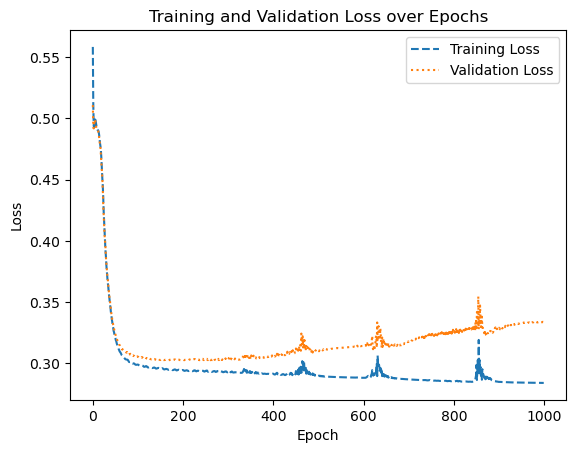

In [51]:
# Set seeds for reproducibility
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

# Creating the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(15,)),  # Adjust input shape based on feature count
    tf.keras.layers.Dense(8, activation='linear'),
    tf.keras.layers.Dense(23, activation='relu'),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.026526058661021926)
# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for 1000 epochs (each epoch uses the full training set, i.e. BGD)
history = model.fit(X_train, y_train, epochs=1000, batch_size=len(X_train), verbose=0,
                   validation_data=(X_val, y_val))

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss', linestyle="--")                # Extract training loss values from history
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle=":")           # Extract validation loss values from history
plt.xlabel('Epoch')                                                                     # Label x-axis as 'Epoch'
plt.ylabel('Loss')                                                                      # Label y-axis as 'Loss'
plt.title('Training and Validation Loss over Epochs')                                   # Add a title to the plot
plt.legend()                                                                            # Add a legend
plt.show()     

In [33]:
# Using StratifiedKFold cross validation
from sklearn.model_selection import StratifiedKFold
import numpy as np
from tensorflow.keras.models import clone_model
from sklearn.metrics import f1_score

# Set seeds for reproducibility
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

# List of epoch values to test
epoch_list = [50,75, 100, 125, 150,175, 200, 225, 250, 275, 300,325, 350,375, 400,425, 450,475, 500]
results = {}

# Creating the model
final_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(15,)),  # Adjust input shape based on feature count
    tf.keras.layers.Dense(8, activation='linear'),
    tf.keras.layers.Dense(23, activation='relu'),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Assume X, y are your input data and labels, and final_model is your tuned Keras model
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=888)

for epoch in epoch_list:
    f1_scores = []
    for train_idx, val_idx in strat_kfold.split(X, y):
        # Split data for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        scaler = StandardScaler()
        age_index = 1
        # Fit the scaler only on the age column in X_train
        X_train_age = X_train[:, age_index].reshape(-1, 1)
        scaler.fit(X_train_age)
        # Transform the age column in X_train and X_val
        X_train[:, age_index] = scaler.transform(X_train_age).flatten()
        X_val[:, age_index] = scaler.transform(X_val[:, age_index].reshape(-1, 1)).flatten()

        # Clone the model to reset weights for each fold
        model = clone_model(final_model)
        opt = tf.keras.optimizers.Adam(learning_rate=0.026526058661021926)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
        # Train the model on this fold
        model.fit(X_train, y_train, epochs=epoch, batch_size=len(X_train), verbose=0)
    
        # Predict and evaluate F1 score for this fold
        y_pred = (model.predict(X_val) > 0.5).astype(int)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        
    results[epoch] = np.mean(f1_scores)
    print(f"Average F1 Score for {epoch} epochs: {results[epoch]}")



StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step
Average F1 Score for 50 epochs: 0.9427090197343688


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
Average F1 Score for 75 epochs: 0.9446950619409862


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step
Average F1 Score for 100 epochs: 0.9345588287692621


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step
Average F1 Score for 125 epochs: 0.9443041469642649


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step
Average F1 Score for 150 epochs: 0.9457183647269011


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
Average F1 Score for 175 epochs: 0.9455522951549848


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
Average F1 Score for 200 epochs: 0.9451817701074731


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
Average F1 Score for 225 epochs: 0.935302684663015


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
Average F1 Score for 250 epochs: 0.945313049415681


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step
Average F1 Score for 275 epochs: 0.9339546602106431


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
Average F1 Score for 300 epochs: 0.9456888659764292


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step
Average F1 Score for 325 epochs: 0.9449919634197415


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
Average F1 Score for 350 epochs: 0.9240310258540256


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step
Average F1 Score for 375 epochs: 0.9456003832430702


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
Average F1 Score for 400 epochs: 0.9453381206200545


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step
Average F1 Score for 425 epochs: 0.9450276382362913


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
Average F1 Score for 450 epochs: 0.9453600608734657


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step
Average F1 Score for 475 epochs: 0.9337259330470298


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


StandardScaler()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step
Average F1 Score for 500 epochs: 0.9346559615123912


{50: 0.9427090197343688,
 75: 0.9446950619409862,
 100: 0.9345588287692621,
 125: 0.9443041469642649,
 150: 0.9457183647269011,
 175: 0.9455522951549848,
 200: 0.9451817701074731,
 225: 0.935302684663015,
 250: 0.945313049415681,
 275: 0.9339546602106431,
 300: 0.9456888659764292,
 325: 0.9449919634197415,
 350: 0.9240310258540256,
 375: 0.9456003832430702,
 400: 0.9453381206200545,
 425: 0.9450276382362913,
 450: 0.9453600608734657,
 475: 0.9337259330470298,
 500: 0.9346559615123912}

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'F1 Score')

Text(0.5, 1.0, 'Line Graph of Epoch against F1 score')

Text(130, 0.9307183647269011, 'Max Chosen\n(X=150, Y=0.9457)')

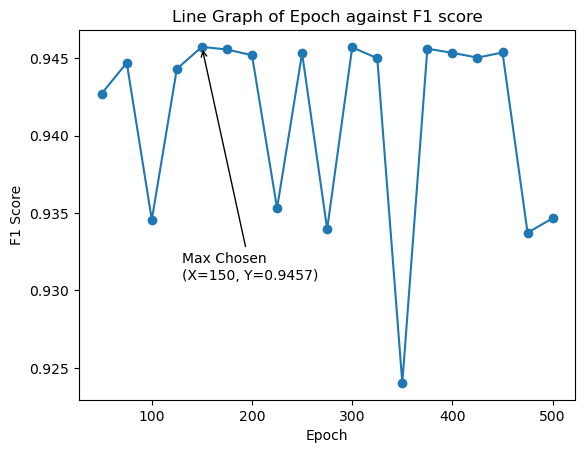

In [45]:
results # Epoch 200 is the ideal

# Plotting the data as a line graph
x_values = list(results.keys())
y_values = list(results.values())
# Coordinates for annotation
x_annotation = 150
y_annotation = results[x_annotation]

plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Line Graph of Epoch against F1 score')
plt.annotate(f'Max Chosen\n(X=150, Y={y_annotation:.4f})',
             xy=(x_annotation, y_annotation), xytext=(x_annotation-20, y_annotation-0.015),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Training and Validation Loss over Epochs')

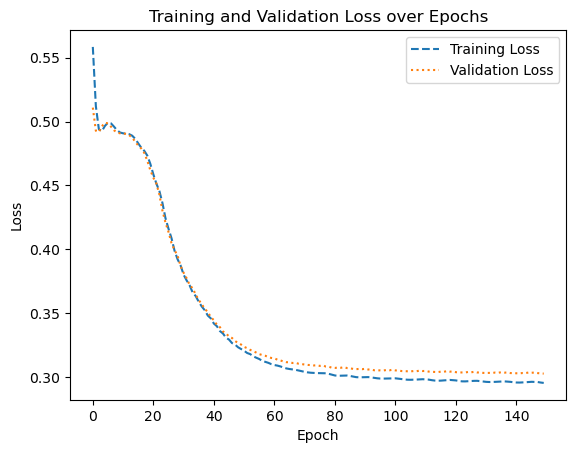

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
Best model Precision on validation set: 0.895910780669145
Best model Recall on validation set: 0.9979296066252588
Best model F1 score on validation set: 0.9441723800195886


In [52]:
# Set seeds for reproducibility
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

# Creating the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(15,)),  # Adjust input shape based on feature count
    tf.keras.layers.Dense(8, activation='linear'),
    tf.keras.layers.Dense(23, activation='relu'),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.026526058661021926)
# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for 1000 epochs (each epoch uses the full training set, i.e. BGD)
history = model.fit(X_train, y_train, epochs=150, batch_size=len(X_train), verbose=0,
                   validation_data=(X_val, y_val))

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss', linestyle="--")                # Extract training loss values from history
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle=":")           # Extract validation loss values from history
plt.xlabel('Epoch')                                                                     # Label x-axis as 'Epoch'
plt.ylabel('Loss')                                                                      # Label y-axis as 'Loss'
plt.title('Training and Validation Loss over Epochs')                                   # Add a title to the plot
plt.legend()                                                                            # Add a legend
plt.show()     

# Make predictions on the validation set
y_val_pred = (model.predict(X_val) > 0.5).astype("int32")  # Threshold at 0.5 for binary classification

# Calculate F1 score
f1 = f1_score(y_val,y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)

print("Best model Precision on validation set:", precision)
print("Best model Recall on validation set:", recall)
print("Best model F1 score on validation set:", f1)